In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

from torchsummary import summary


In [2]:
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
import os
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')


import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## tqdm for loading bars
from tqdm.notebook import tqdm


import torch
## Torchvision
import torchvision
from torchvision.datasets import STL10
from torchvision import transforms

<Figure size 640x480 with 0 Axes>

In [3]:
from src.models.simclr import SimCLR as SimCLRD
from src.data.self_supervised_dm import ContrastiveDataSet as ContrastiveDataSetD, ContrastiveDataModule

# ContrastiveDataSet

Two augmentations stand out in their importance: crop-and-resize, and color distortion. Interestingly, however, they only lead to strong performance if they have been used together as discussed by Ting Chen et al. in their SimCLR paper

In [4]:
import torch.utils.data as data
from pathlib import Path
import numpy as np
import random
import SimpleITK as sitk
from src.utils.general import crop_image_to_content, resample_volume

# path to synstheg generated images and label maps folders
sytnthseg_path = Path('/mrhome/vladyslavz/git/central-sulcus-analysis/data/synthseg/nobackup')


class ContrastiveDataSet(data.Dataset):
    def __init__(self, dataset, nviews=2,
                 skull_strip:bool | float = True,
                 resample: list[float] | None = None,
                 crop2content: bool = False,
                 padd2same_size: bool = False
                 ):
        """ContrastiveDataSet

        Args:
            dataset (str): Which dataset to use for contrastive learning.
                Available datasets: 'synthseg'.
            nviews (int, optional): How many agumented images of the same labelmap tp load . Defaults to 2.
            skull_strip (bool|float, optional): Whether to load skull-stripped images or not. 
                If a float given, removes the skull with a given probability.
                Defaults to True (always removes the skull & face).
            resample (list[x, y, z] | None, optional): Resample the images to a given resolution.

        """
        self.dataset = dataset
        self.nviews = nviews
        self.skull_strip = skull_strip
        self.resample = list(resample) if resample is not None else None
        self.crop2content = crop2content
        self.padd2same_size = padd2same_size
        
        if dataset == 'synthseg':
            self._load_synthseg()
        else:
            raise ValueError(f'Unknown dataset: {dataset}')


    def __getitem__(self, index):
        img_path = self.img_dirs[index]
        all_img_views = [x for x in img_path.glob('image*.nii.gz')]
        views_paths = [all_img_views[random.randint(0,len(all_img_views)-1)]\
                        for i in range(self.nviews)]
        
        views_images = self._load_images(views_paths)
                    
        return views_images
    def __len__(self):
        return len(self.img_dirs)
    
    def _load_synthseg(self):
        self.img_dirs = [x for x in sytnthseg_path.iterdir() if x.is_dir()]
        
    def _load_images(self, views_paths):
        
        # load and convert to numpy
        images = [sitk.ReadImage(str(p)) for p in views_paths]
        images = [self._preporces_sitk(img) for img in images]
        images = [sitk.GetArrayFromImage(img) for img in images]
        
        # skull strip
        if self.skull_strip:
            images = self._skull_strip(images, views_paths)
        
        # min-max normalization
        images = [(i - i.min())/(i.max() - i.min()) for i in images]
        
        # convert to torch tensors and return
        images = [torch.tensor(i, dtype=torch.float32) for i in images]
        
        # squeeze the channel dimension
        images = [i.unsqueeze(0) for i in images]
        return images
    
    def _skull_strip(self, images, image_paths):
        
        # if skull_strip is a float, remove the skull with a given probability
        if isinstance(self.skull_strip, float) and 0.<= self.skull_strip <= 1.:
            if random.random() >= self.skull_strip:
                return images
        
        # load labels
        lable_paths = [str(x).replace('image', 'labels') for x in image_paths]
        labels = [sitk.ReadImage(p) for p in lable_paths]
        labels = [self._preporces_sitk(img, labelmap=True) for img in labels]
        labels = [sitk.GetArrayFromImage(img) for img in labels]

        # mask outeverything except cortex labels
        cortex_mask = [((x<500)&(x!=0)).astype(np.int16) for x in labels]
        masked_images = [x*y for x,y in zip(images, cortex_mask)]
        return masked_images
    
    def _preporces_sitk(self, img, labelmap=False):
        image_interpolator = sitk.sitkLinear if not labelmap else sitk.sitkNearestNeighbor
        if self.resample is not None:
            img = resample_volume(img, self.resample, image_interpolator)
            return img
        else:
            return img

In [5]:
unlabeled_data = ContrastiveDataSet('synthseg', nviews=2, skull_strip=True,
                                    resample=[2, 2, 2])

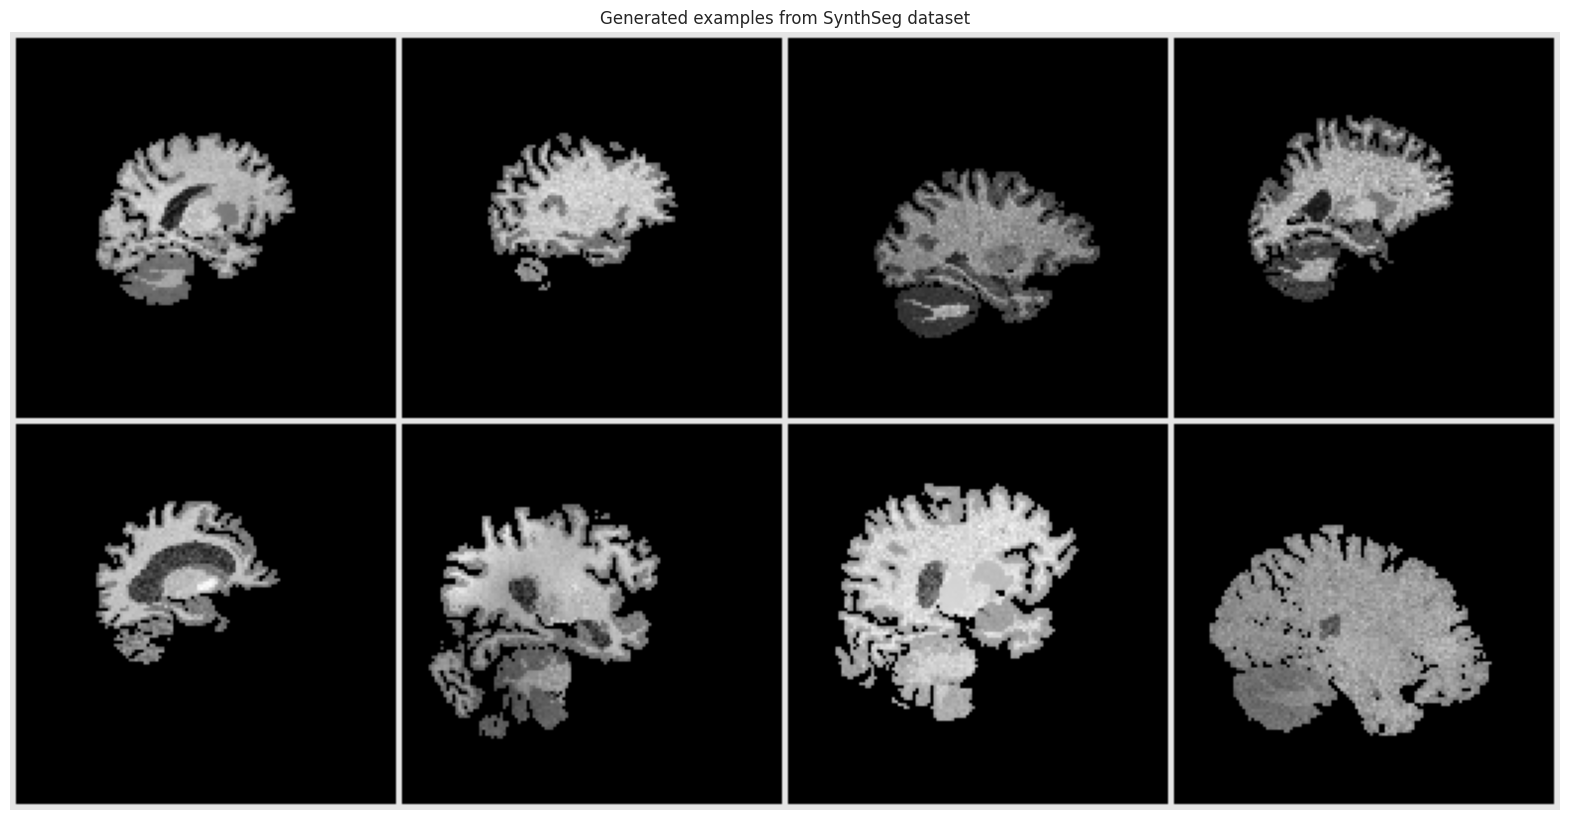

In [6]:
imgs = unlabeled_data[0] + unlabeled_data[1] + unlabeled_data[2] + unlabeled_data[3]
imgs = torch.cat(imgs, dim=0)

# grid_imgs = imgs[:, 128:129, :, :]
grid_imgs = imgs[:, 64:65, :, :] # for 2x2x2 resampling
grid_imgs = imgs[:, :, :, 77:78].permute(0, 3, 2, 1) # for 2x2x2 resampling

img_grid = torchvision.utils.make_grid(grid_imgs, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(20,20))
plt.title('Generated examples from SynthSeg dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [7]:
imgs[:, :, :, 64:65].permute(0, 3, 2, 1).shape

torch.Size([8, 1, 128, 128])

In [8]:
print(imgs.shape)

torch.Size([8, 128, 128, 128])


In [12]:
model

NameError: name 'model' is not defined

So at every step, we randomly choose one of the two augmentations to apply to the image. The two augmentations are returned in a list at each step of the dataset.

# SimCLR Implementation

At each iteration, we get for every image  x  two differently augmented versions, which we refer to as x_i and x_j. Both of these images are encoded into a one-dimensional feature vector, between which we want to maximize similarity which minimizes it to all other images in the batch. The encoder network is split into two parts: a base encoder network f(.) and a projection head g(.). The base network will be a U-Net encoder, and f(x_i) = h_i.
The projection head g(.) is a simple MLP that maps the representation 
into a space where we apply the contrastive loss, i.e., compare similarities between vectors. It is often chosen to be a small MLP with non-linearities, and for simplicity, we follow the original SimCLR paper setup by defining it as a two-layer MLP with ReLU activation in the hidden layer.

Note that in the follow-up paper, SimCLRv2, the authors mention that larger/wider MLPs can boost the performance considerably. This is why we apply an MLP with four times larger hidden dimensions but it can lead to overfitting.

In [75]:
import pytorch_lightning as pl

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from src.models.unet3d.model_encoders import  UNet3D


class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        
        # Base model f(.) output of last linear layer
        self.unet_encoder = UNet3D(in_channels=1,
                                   out_channels=1,
                                   f_maps=(16, 32, 64, 128, 256, 512),
                                   only_encoder=True)

        img_dim = 128
        number_of_layers = 6
        last_layer_kernels = 128
        
        # calculate u-net embeding dimension
        embed_dim = int(last_layer_kernels * ((img_dim/(2)**(number_of_layers-1))**3))  # 8192
        
        hidden_dim = 512 # number of neurons in the MLP head output aka dimensionality of feature vector
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.mlp_head = nn.Sequential(self.unet_encoder,
                                      nn.MaxPool3d(kernel_size=2, stride=2),
                                      nn.Flatten(),
                                      nn.Linear(4096, 4096),
                                      nn.ReLU(inplace=False),
                                      nn.Linear(4096, hidden_dim))
                                    #   nn.Linear(embed_dim, hidden_dim)),

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]
    def forward(self, x):
        return self.mlp_head(x)
    
    def info_nce_loss(self, batch, mode='train'):
        imgs = batch
        # imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.mlp_head(imgs)
        
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

In [76]:
model = SimCLR(hidden_dim=2048, lr=1e-3, temperature=0.1, weight_decay=1e-6, max_epochs=500)

In [84]:
summary(model.to('cuda'), input_size=(1, 128, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         GroupNorm-1     [-1, 1, 128, 128, 128]               2
         GroupNorm-2     [-1, 1, 128, 128, 128]               2
            Conv3d-3     [-1, 8, 128, 128, 128]             216
            Conv3d-4     [-1, 8, 128, 128, 128]             216
              ReLU-5     [-1, 8, 128, 128, 128]               0
              ReLU-6     [-1, 8, 128, 128, 128]               0
         GroupNorm-7     [-1, 8, 128, 128, 128]              16
         GroupNorm-8     [-1, 8, 128, 128, 128]              16
            Conv3d-9    [-1, 16, 128, 128, 128]           3,456
           Conv3d-10    [-1, 16, 128, 128, 128]           3,456
             ReLU-11    [-1, 16, 128, 128, 128]               0
             ReLU-12    [-1, 16, 128, 128, 128]               0
          Encoder-13    [-1, 16, 128, 128, 128]               0
          Encoder-14    [-1, 16, 128, 1

In [10]:
model2 = SimCLRD(hidden_dim=2048, lr=1e-3, temperature=0.1, weight_decay=1e-6, max_epochs=500,
                 img_dim=128, optimizer='adam', scheduler='cosine', encoder=UNet3D(in_channels=1,
                                   out_channels=1,
                                   f_maps=(4, 8, 16, 32, 64, 128),
                                   only_encoder=True))

/mrhome/vladyslavz/anaconda3/envs/css/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:263: UserWarning: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
  rank_zero_warn(


In [15]:
imgs_input = imgs.unsqueeze(dim=1)

In [16]:
model.training_step(imgs_input, 0)

/mrhome/vladyslavz/anaconda3/envs/css/lib/python3.10/site-packages/pytorch_lightning/core/module.py:416: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


tensor(2.7714, grad_fn=<MeanBackward0>)

In [17]:
model2.training_step(imgs_input, 0)

/mrhome/vladyslavz/anaconda3/envs/css/lib/python3.10/site-packages/pytorch_lightning/core/module.py:416: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


tensor(2.6967, grad_fn=<MeanBackward0>)

In [9]:
dm = ContrastiveDataModule({'dataset':'synthseg',
                                        'nviews':2, 'skull_strip':0.5,
                                        'resample':[2, 2, 2]},2,2,1)

In [25]:
dl = data.DataLoader(
            dm.train_dataset,
            batch_size=2,
            shuffle=True,
            num_workers=1,
            drop_last=True,
            pin_memory=True)

In [26]:
[x.shape for x in dm.train_dataset[0][0]]

[torch.Size([1, 128, 128, 128]), torch.Size([1, 128, 128, 128])]

In [41]:
collate_input  = [dm.train_dataset[0], dm.train_dataset[1]]

In [42]:
res = torch.utils.data.default_collate(collate_input)

In [48]:
res[1]

tensor([-1, -1])

In [51]:
[x.shape for x in res[0]]

[torch.Size([2, 1, 128, 128, 128]), torch.Size([2, 1, 128, 128, 128])]

In [27]:
for i in dl:
    print(i[0].shape)
    break

KeyboardInterrupt: 

In [15]:
imgs = dm.train_dataset[0]

In [19]:
imgs[0][0].shape

torch.Size([1, 128, 128, 128])